# Volatility Models: DCC

This notebook estimates a multivariate GARCH model. We first apply an EWMA approach, then MLE.

As an alternative, consider the [ARCHModels.jl](https://github.com/s-broda/ARCHModels.jl) package.

## Load Packages and Extra Functions

This notebook uses likelihood functions from the (local) `FinEcmt_TimeSeries` module and then calls on the `MLE()` function from the (local) `FinEcmt_MLEGMM` module.

In [1]:
MyModulePath = joinpath(pwd(),"src")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath)
using FinEcmt_OLS, FinEcmt_TimeSeries
using FinEcmt_MLEGMM: MLE

In [2]:
#=
include(joinpath(pwd(),"src","FinEcmt_OLS.jl"))
include(joinpath(pwd(),"src","FinEcmt_TimeSeries.jl"))
include(joinpath(pwd(),"src","FinEcmt_MLEGMM.jl"))
using .FinEcmt_OLS, .FinEcmt_TimeSeries
using .FinEcmt_MLEGMM: MLE
=#

In [3]:
using Dates, DelimitedFiles, Statistics, LinearAlgebra

In [4]:
using Plots
default(size = (480,320),fmt = :png)

## Load Data

for two return series (called `R9` and `R10`).

In [5]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2:end]             #returns for 10 different size portfolios
xx  = nothing

R9 = R[2:end,9]                           #returns, 2nd largest firms
x9 = [ones(size(R9)) R[1:end-1,9]]        #regressors, [1, R9(t-1)]

R10 = R[2:end,10]                         #returns, largest firms
x10 = [ones(size(R10)) R[1:end-1,10]]     #regressors, [1, R10(t-1)]

dN = Date.(string.(ymd),"yyyymmdd");      #to Julia dates

# EWMA-DCC

We first apply the DCC approach by using an EWMA approach.

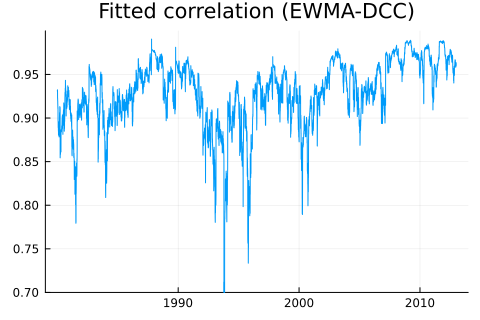

In [6]:
λ = 0.97
(_,R,_,_) = Dcc_EWMA([R9 R10],λ)                #R is a correlation matrix

xTicksLoc = [Date(1990),Date(2000),Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN[2:end],R[:,1,2],
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           ylims  = (0.7,1),
           title = "Fitted correlation (EWMA-DCC)" )
display(p1)

# DCC: Estimate Univariate eGARCH(1,1) Models

for each of the two return series. Also, calculate the standardized residuals as 
$v_t = u_t/\sigma_t$.  

The estimation is done by the `MLE()` function from the `FinEcmt_MLEGMM` module. It wants at least four inputs: (`LLfunction,startingGuess,y,x`), but can also accept lower and upper bounds on the estimated parameters.

In [7]:
y = [R9 R10]                  #Tx2 (Txn)
x = cat(x9,x10,dims=3)        #TxKx2
(T,K,n) = size(x)

par0 = [mean(R9),0,var(R9)*0.05,0.05,0.90,0]   #initial parameter guess: b0,b1,ω,α,β,γ

lower = [-Inf,-0.99,-Inf,-Inf,0,-Inf]              #upper and lower bounds on the parameters
upper = [ Inf, 0.99, Inf, Inf,1, Inf]

egarch11LL_(par,y,x) = egarch11LL(par,y,x)[1];      #to get a function with just one output

In [8]:
(v,σ²) = (fill(NaN,T,n),fill(NaN,T,n))  #to fill with results, stand. residuals, variances
parHat   = fill(NaN,K+4,n)        #estimated parameters 
for i in 1:n             #loop over estimations of y[:,i]
    local y_i,x_i
    (y_i,x_i) = (y[:,i],x[:,:,i])
    parHat_i, = MLE(egarch11LL_,par0,y_i,x_i,lower,upper)    #estimate
    (_,σ²[:,i],_,_,v[:,i]) = egarch11LL(parHat_i,y_i,x_i)    #fitted values
    parHat[:,i] = parHat_i
end    

printblue("eGARCH(1,1), parameter estimates:\n")
coefNames = ["b₀","b₁","ω","α","β","γ"]
printmat(parHat;colNames=["asset 1","asset 2"],rowNames=coefNames)

eGARCH(1,1), parameter estimates:

     asset 1   asset 2
b₀     0.042     0.041
b₁     0.100     0.001
ω     -0.116    -0.100
α      0.147     0.130
β      0.980     0.982
γ     -0.088    -0.085



## DCC: Estimation

This section estimates a DCC model by ML from the two series of standardized residuals (from the eGARCH estimation above).

The cells below use the `MLE()` function to estimate the DCC. However, the structure of the DCC model is a bit different from the main use case for `MLE()`. In particular, notice 

1. To impose the necessary restrictions ($\alpha,\beta$ being positive and summing to less than 1), we estimate `(a,b)` but they imply the following `(α,β)` via the `DccParTrans()` function:
$\alpha = e^a/(1+e^a+e^b)$ and 
$\beta = e^b/(1+e^a+e^b)$.
2. We use the `DccLL_()` function for the loglikelihood. It's the same as the `DccLL()` function, except that it only outputs the loglikelihood contributions.
3. We call as `MLE(DccLL_,par0,data,nothing)`, where `par0` are starting guesses for `(a,b)` and  `data` is a vector of arrays, where `v = data[1], σ² = data[2], Qbar = data[3]`. The last argument is redundant (there are no "regressors" in this case).

In [9]:
#@doc2 DccLL

In [10]:
par0 = [0.2,1.5]                #Initial guess of

#(α,β) = DccParTrans(par0)       #we estimate (a,b), but they imply (α,β)
#println("Initial guess of parameters")
#printmat([α,β];colNames=["coef"],rowNames=["α","β"])

Qbar = cov(v)                   #unconditional covariance matrix of v
data = [v,σ²,Qbar]              #vector of arrays, unpacked inside DccLL

DccLL_(par,y,x) = DccLL(par,y,x)[1]         #LL function, just one output
parHat, = MLE(DccLL_,par0,data,nothing)
(α,β)  = DccParTrans(parHat)                              #(a,b) -> (α,beta)

println("Estimated parameters")
printmat(parHat,[α,β];colNames=["(a,b)","(α,β)"],rowNames=["(a) α","(b) β"])

Estimated parameters
          (a,b)     (α,β)
(a) α     0.954     0.024
(b) β     4.669     0.967



## DCC: Calculate the Fitted Variance-Covariance and Correlation Matrices

The next cell calculates the fitted variance-covariance matrices (`nxnxT`) by using the point estimates and data in the likelihood function, exported as the 2nd output. It then converts the results to the implied correlation, which we plot.

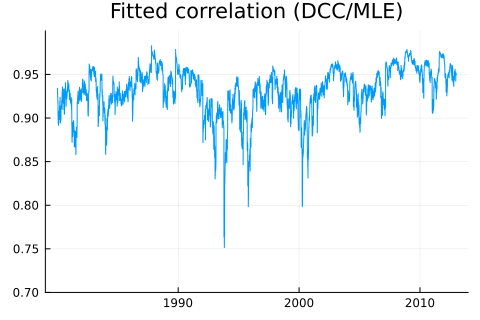

In [11]:
(_,S,R) = DccLL(parHat,data)            #Txnxn, T fitted covariance matrices

xTicksLoc = [Date(1990),Date(2000),Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN[2:end],R[:,1,2],
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           ylims  = (0.7,1),
           title = "Fitted correlation (DCC/MLE)" )
display(p1)